# Text classification with the torchtext library

Based on the tutorial: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

```
# install dependency
pip install -U portalocker>=2.0.0
```

This notebook provides an introduction to text classification using the torchtext library and PyTorch, demonstrating how to work with text data, define models, train them, and evaluate their performance. It uses the AG_NEWS dataset for demonstration purposes.

The dataset is loaded using `torchtext.datasets.AG_NEWS` and processed to create iterators for training and testing. The data is then tokenized and transformed into numerical representations using n-grams.

A simple neural network model is defined using `torch.nn.Module`, consisting of an embedding layer, a convolutional layer, and a fully connected layer. The model is trained using the SGD optimizer and cross-entropy loss function. There's a scheduler to decrease the learning rate over time (decreases the learning rate by a factor of `gamma=0.1` every `step_size=1` epochs). The training loop iterates over the dataset for a specified number of epochs, updating the model parameters to minimize the loss.

After training, the model is evaluated on the test set to measure its accuracy. The evaluation loop computes the accuracy by comparing the model's predictions with the true labels.

Additionally, the notebook includes code to save the trained model's state dictionary to a file and load it back for inference. This allows for the model to be reused without retraining.

Metrics about the training are printed after every 500 batches and at the end of each epoch. The notebook concludes with a section on visualizing the model's predictions on a few test samples, providing a qualitative assessment of the model's performance.

Most of the boilerplate for the training is handled by the manager class. This includes printing metrics during training and periodically saving the model, allowing training to be resumed from the last checkpoint.

The original tutorial uses a collate function that returns batches as a tuple of 3 elements: the tensor of labels, input texts concatenated in a tensor, and offsets (the cumulative positions of the start of each sentence in the input tensor). The manager expects the dataloaders to yield a batch as a tuple of `(input, target)`, so the collate function was changed to return a tuple of 2 elements, where the first element is a list of texts and the second is a tensor of labels (with the first dimension having one element for each item in the batch). In the executor, the list of texts is used to generate the offsets, and the texts are concatenated into a tensor to be used as input. 

Alternatively, the collate function could return the first element in the tuple as a list of tuples, each containing 2 elements: the text (tensor) and the corresponding offset (integer) of the dataset item. The executor would then concatenate the texts into one tensor and the offsets into another tensor. See [seq2seq_translation.ipynb](./seq2seq_translation.ipynb) for such an approach.

The evaluator `MaxProbEvaluator` receives the output from the executor, which is expected to be a tensor with probabilities for different categories. It returns an object with a `prediction` attribute that is a tuple containing the probability and the label with the highest probability. When calling `manager.evaluate(input)`, it runs the evaluator, which processes the input to give an output, and then processes the output of the model to get the category with the highest probability.

The function `predict`, very similar to the one in the original tutorial, transforms the text input into a tensor using the pipeline, calls the evaluation function, and retrieves the label, adding 1 to get the category ID. Alternatively, a custom evaluator could be created to receive the input as a string and output the category ID (or the name of the category). It could even just print the result, such as `This is a {category_name} news`, returning nothing. See [char_rnn_generation.ipynb](./char_rnn_generation.ipynb) for an example of such a custom evaluator.

A custom metrics class was used to calculate and display metrics related to losses, accuracy, and training times, which were then saved to a PDF file (`REPORT_PATH`). You can find implementation examples of various metrics classes in [lib/metrics.py](../lib/metrics.py).

In [37]:
NAME = 'text_sentiment_ngrams'
SAVE_PATH = f'data/test/train/{NAME}-checkpoint.pth'
REPORT_PATH = f'data/test/train/{NAME}-report.pdf'
ROOT_DIR = 'data/ag_news'

In [38]:
import sys
if "../" not in sys.path:
  sys.path.append("../")

In [39]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

### Access to the raw dataset iterators

In [40]:
import torch
import typing
from torchtext.datasets import AG_NEWS

iterable: typing.Any = AG_NEWS(root=ROOT_DIR, split="train")
train_iter = iter(iterable)

In [41]:
next(train_iter)

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

### Prepare data processing pipelines

In [42]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
train_iter = AG_NEWS(root=ROOT_DIR, split="train")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [43]:
vocab(['here', 'is', 'an', 'example'])

[475, 21, 30, 5297]

In [44]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [45]:
text_pipeline('here is the an example')

[475, 21, 2, 30, 5297]

In [46]:
label_pipeline('10')

9

### Generate data batch and iterator

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    return text_list, label_list

### Define the model

In [48]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

### Initiate an instance

In [49]:
train_iter = AG_NEWS(root=ROOT_DIR, split="train")
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

### Split the dataset

In [50]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader

BATCH_SIZE = 64  # batch size for training

train_iter, test_iter = AG_NEWS(root=ROOT_DIR, split=('train', 'test')) # type: ignore
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader: DataLoader[tuple[list[torch.Tensor], torch.Tensor]] = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader: DataLoader[tuple[list[torch.Tensor], torch.Tensor]] = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader: DataLoader[tuple[list[torch.Tensor], torch.Tensor]] = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

### Define the Manager

In [51]:
from auto_mind import supervised
from auto_mind.supervised.handlers import MaxProbEvaluator, GeneralBatchAccuracyCalculator, BatchExecutor, BatchExecutorParams
from src.lib.metrics import MainMetrics

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1)

class MyBatchExecutor(BatchExecutor[list[torch.Tensor], torch.Tensor]):
    def run(self, params: BatchExecutorParams[list[torch.Tensor]]) -> torch.Tensor:
        model = params.model
        text_list = params.input
        texts_cat = torch.cat(text_list)
        all_offsets = [0] + [len(text) for text in text_list]
        offsets = torch.tensor(all_offsets[:-1]).cumsum(dim=0)
        predicted_label = model(texts_cat, offsets)
        return predicted_label

manager = supervised.Manager(
    data_params=supervised.ManagerDataParams(
        train_dataloader=train_dataloader,
        validation_dataloader=valid_dataloader,
        test_dataloader=test_dataloader,
    ),
    model_params=supervised.ManagerModelParams(
        model=model,
        criterion=criterion,
        executor=MyBatchExecutor(),
        use_best=False,
        clip_grad_max=0.1,
    ),
    optimizer_params=supervised.ManagerOptimizerParams(
        optimizer=optimizer,
        scheduler=scheduler,
        step_only_on_accuracy_loss=True,
    ),
    metrics_params=supervised.ManagerMetricsParams(
        evaluator=MaxProbEvaluator(executor=MyBatchExecutor()),
        accuracy_calculator=GeneralBatchAccuracyCalculator(),
        metrics_calculator=MainMetrics(name=NAME).as_file_plotter(REPORT_PATH, figsize=(8, 8)),
        batch_interval=True,
        default_interval=500,
    ),
    config=supervised.ManagerConfig(
        save_path=SAVE_PATH,
        random_seed=0,
    ),
)

### Run the model (training + validation + test)

Starting training for 10 epochs...
> [train] [epoch 1 ( 10.0%)] [batch:  500/1782] [time:   0m 13.02s] [accuracy:  68.5%] [loss: 0.0128]
> [train] [epoch 1 ( 10.0%)] [batch: 1000/1782] [time:   0m 24.15s] [accuracy:  85.3%] [loss: 0.0068]
> [train] [epoch 1 ( 10.0%)] [batch: 1500/1782] [time:   0m 34.76s] [accuracy:  87.7%] [loss: 0.0058]
> [train] [epoch 1 ( 10.0%)] [batch: 1782/1782] [time:   0m 40.89s] [accuracy:  88.6%] [loss: 0.0055]
------------------------------------------------------------------------------------------------------
> [validation] [epoch 1 ( 10.0%)] [batch: 94/94] [time:    0m 0.36s] [accuracy:  87.5%] [loss: 0.0058]
------------------------------------------------------------------------------------------------------------------------------------------------------
[end of epoch 1 ( 10.0%)] [time:   0m 41.32s (eta:   6m 11.86s)] [val_accuracy:  87.5%, train_accuracy:  81.8%] [val_loss: 0.0058, train_loss: 0.0080]
> [train] [epoch 2 ( 20.0%)] [batch:  500/1782] [

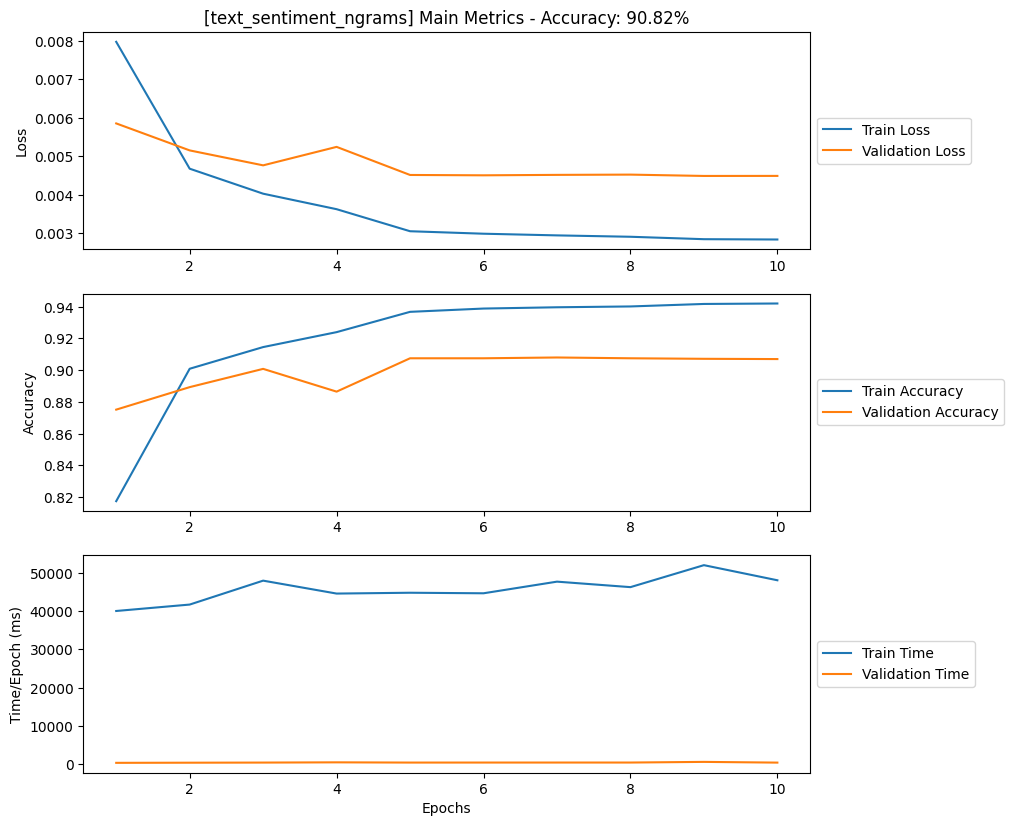

In [52]:
manager.train(epochs=10)

### Test on a random news

In [53]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}

model = model.to("cpu")

def predict(text: str, text_pipeline: typing.Callable[[str], typing.Any]) -> int:
    with torch.no_grad():
        text_tensor = torch.tensor(text_pipeline(text))
        result = manager.evaluate([text_tensor])
        _, label = result.prediction
        return label + 1

In [54]:
# Sports example
ex_text_str = "MEMPHIS, Tenn. - Four days ago, Jon Rahm was \
    enduring the season's worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday's first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he'd never played the \
    front nine at TPC Southwind."
print("This is a %s news" % ag_news_label[predict(ex_text_str, text_pipeline)])

This is a Sports news


In [55]:
# Business example
ex_text_str = "Intel Corp. on Thursday reported second-quarter profit of $5.06 billion."
print("This is a %s news" % ag_news_label[predict(ex_text_str, text_pipeline)])

This is a Business news


In [56]:
# Sci/Tec example
ex_text_str = "The U.S. Department of Commerce is set to announce a new set of regulations on Wednesday that are aimed at limiting exports of specific technologies to China."
print("This is a %s news" % ag_news_label[predict(ex_text_str, text_pipeline)])

This is a Sci/Tec news


In [57]:
# World example
ex_text_str = "In Oceania, there are only four countries, with the biggest being Australia."
print("This is a %s news" % ag_news_label[predict(ex_text_str, text_pipeline)])

This is a World news
